In [1]:
!pip install psycopg2

In [1]:
import psycopg2 as ps
import psycopg2.extras as e
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import itertools as iter

In [2]:

PATH_SPLIT_DATA='C:\\Users\\Public\\CS645\\see_db_dataset\\splits'

def split_data(splits):
    data_raw = pd.read_csv(r'C:\\Users\\Public\\CS645\\see_db_dataset\\adult.txt')
    data_split = np.array_split(data_raw, splits)
    for k in range(1, len(data_split)+1):
        data_split[k-1].to_csv(os.path.join(PATH_SPLIT_DATA ,"split_{}.csv".format(k)),encoding='utf-8', index=False)

split_data(10)

In [3]:
con = ps.connect("dbname='see_db' user='postgres' host='localhost' password='bluemoon0512'")
curs = con.cursor()

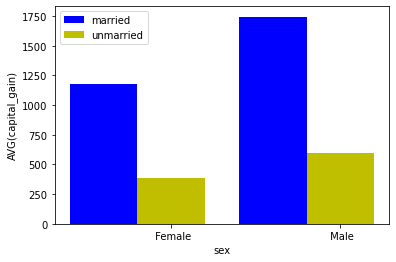

In [4]:
curs.execute("""create or replace view married as 
                   select * from census where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
           create or replace view unmarried as 
                   select * from census where marital_status in (' Never-married', ' Widowed',' Divorced');""")
con.commit()

curs.execute("select sex, avg(capital_gain) from married group by sex;")
target = curs.fetchall()

curs.execute("select sex, avg(capital_gain) from unmarried group by sex;")
reference = curs.fetchall()

def create_plot(afm, reference, target):
    group_attr,function, measure = afm
    plt.subplots()
    graph1 = plt.bar(np.arange(len(target)), target.values(), 0.4, color = 'b', label = 'married')
    graph2 = plt.bar(np.arange(len(target))+0.4, reference.values(), 0.4, color = 'y', label = 'unmarried')
    
    plt.xlabel('{}'.format(group_attr))
    plt.ylabel('{}({})'.format(function, measure))
    plt.xticks(np.arange(len(target))+0.4, target.keys())
    plt.legend()

    plt.show()

afm_plot = ('sex', 'AVG', 'capital_gain')
create_plot(afm_plot, dict(reference), dict(target))

In [5]:
def normalize(data):
    if len(data) > 0:
        return [(i - np.min(data)) / (np.max(data) - np.min(data)) for i in data]
    return 0

#K-L divergence
def kl_divergence(ref_data, tar_data):
    ref_nor = normalize(ref_data)
    tar_nor = normalize(tar_data)
    pro_ref = [i/np.sum(ref_nor) for i in ref_nor]
    pro_tar = [i/np.sum(tar_nor) for i in tar_nor]
    kl = np.sum([qi  * np.log(qi/pi) for qi, pi in zip(pro_tar, pro_ref) if pi>0 and qi>0])
    return kl

In [6]:
#phased execution

for i in range(10):
    curs.execute("""create or replace view test{}_married as 
                   select * from test{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view test{}_unmarried as 
                   select * from test{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i+1,i+1,i+1,i+1))
    con.commit()

In [35]:
funcs = ['sum', 'count', 'avg']
group_by_col = ["economic_indicator", "workclass", "occupation", "education", "race", "native_country", "sex", "relationship"]
measure_col = ["capital_loss", "capital_gain", "age", "fnlwgt", "hours_per_week"]

views = {pos:combo for pos, combo in enumerate(list(iter.product(funcs, measure_col, group_by_col)))}
tables = ['married', 'unmarried']

In [24]:
def share_based_optimization(tables, views, phase):
    print("in share_based_optimization")
    kl_dict={}
    for table in tables:
        for i, (f, m, a) in views.items():
            query="create or replace view vi_{} as select {}, {}({}) from test{}_{} group by {};".format(table+"_"+str(i),a,f,m,phase,table,a)
            curs.execute(query)
            con.commit()
            kl_dict[f+"-"+m+"-"+a]=["vi_"+str(table+"_"+str(i))]
    print("done")
    return kl_dict


In [16]:
def get_views_scores(views, curs):
    print("running get view scores...")
    views_scores = dict()

    for vid, (f, m, a) in views.items():
        tgt_sql_query = 'SELECT * FROM vi_unmarried_{}'.format(vid)
        curs.execute(tgt_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        tgt_df = pd.DataFrame(data, columns=cols)


        ref_sql_query = 'SELECT * FROM vi_married_{}'.format(vid)
        curs.execute(ref_sql_query)
        data = curs.fetchall()
        cols = [desc[0] for desc in curs.description]
        ref_df = pd.DataFrame(data, columns=cols)

        temp_df = tgt_df.join(ref_df.set_index(a), on=a, how='inner', lsuffix='_target', rsuffix='_reference')
        

        tgt_val = temp_df['{}_target'.format(f)].values
        ref_val = temp_df['{}_reference'.format(f)].values

        score = kl_divergence(tgt_val, ref_val)
        views_scores[vid] = score
    print("done")
    return views_scores


In [36]:
def pruning(views, phase):
    delta = 0.05
    N = 10
    K = 5
#     for i in range(10):
    print("Pruning for i = " + str(i))
    m = i+1
    if m == 1:
        return views
    eps = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))
    current_scores = get_views_scores(views, curs)
    sorted_scores = {k: v for k, v in sorted(current_scores.items(), key=lambda item: item[1], reverse=True)}
    top_k_smallest_lower_bound = np.mean(list(sorted_scores.values())[K]) - eps
#         values = list(current_scores.values())
#         mu = sum(values)/len(values)
#         confidence_interval
    
    for k, v in sorted_scores.items():
        if np.mean(v) + eps < top_k_smallest_lower_bound:
            print("deleting view " + str(k))
            del views[k]
    return views

In [37]:
for i in range(10):
    kl_dicts = share_based_optimization(tables, views, i+1)
    pruning(views, i+1)

in share_based_optimization
done
Pruning for i = 0
in share_based_optimization
done
Pruning for i = 1
running get view scores...
done
in share_based_optimization
done
Pruning for i = 2
running get view scores...
done
in share_based_optimization
done
Pruning for i = 3
running get view scores...
done
in share_based_optimization
done
Pruning for i = 4
running get view scores...
done
in share_based_optimization
done
Pruning for i = 5
running get view scores...
done
in share_based_optimization
done
Pruning for i = 6
running get view scores...
done
in share_based_optimization
done
Pruning for i = 7
running get view scores...
done
deleting view 89
deleting view 84
deleting view 95
in share_based_optimization
done
Pruning for i = 8
running get view scores...
done
deleting view 0
deleting view 6
deleting view 8
deleting view 14
deleting view 16
deleting view 22
deleting view 24
deleting view 30
deleting view 32
deleting view 38
deleting view 40
deleting view 46
deleting view 48
deleting view 54

In [38]:
# get top 5 views
current_scores = get_views_scores(views, curs)
top_views = {k: v for k, v in sorted(current_scores.items(), key=lambda item: item[1], reverse=True)[:6]}
top_views
for tp in top_views:
    print(views[tp])

running get view scores...
done
('avg', 'capital_loss', 'relationship')
('sum', 'fnlwgt', 'relationship')
('sum', 'capital_loss', 'relationship')
('count', 'capital_loss', 'relationship')
('count', 'capital_gain', 'relationship')
('count', 'age', 'relationship')
